# 1ST DAY APPLICATION:
## Ridge, LASSO, PCR, FA regression

<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\l'
C:\Users\SangmyungHa\AppData\Local\Temp\ipykernel_18612\3123441797.py:69: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Inflation: $\log CPI_t-\log CPI_{t-12}$")


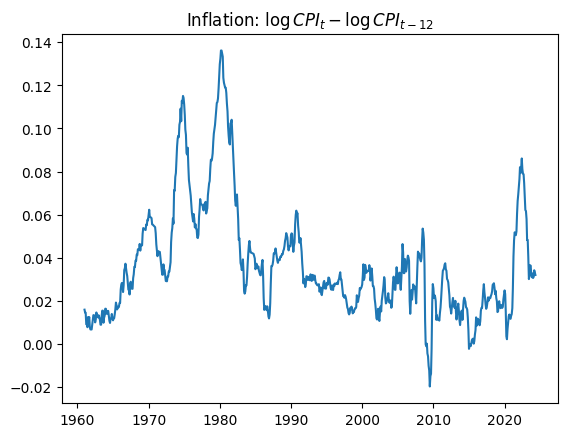

In [1]:
## Inflation Forecast
## Target variable: Year over Year inflation
import os
import time
import pickle
import sqlite3
import numba
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import random
from functions import get_data
import xgboost as xgb
import tensorflow as tf

seed = 42

# Transform:
# Transformation = 'No Transform'
Transformation = 'Transform' 
# :Transforms according to the recommendations given by McCracken and Ng (2015) for all but Group 7 (Prices),
#  which are transformed as year over year growth
# Sample period: 1959.January - 2024.May

Target = 'Inflation'

price_var = ['WPSFD49207', 'WPSFD49502', 'WPSID61', 'WPSID62', 'OILPRICEx', 'PPICMM', 'CPIAUCSL', 
             'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 
             'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA']

lags = 12 # Lags in log difference, lags=12 corresponds to year over year growth rate
X_used, Y_used, Date_used = get_data(Transformation, lags)

n = X_used.shape[0]

forecast_period = pd.to_datetime('2015-01-01')<=Date_used
forecast_idx = np.where(forecast_period)[0]
n_test = np.sum(forecast_period)

validation_period = (pd.to_datetime('2005-08-01')<=Date_used) & (pd.to_datetime('2015-01-01') > Date_used)
validation_idx = np.where(validation_period)[0]
n_val = np.sum(validation_period)

training_period = pd.to_datetime('2005-08-01')>Date_used
training_idx = np.where(training_period)[0]
n_train = np.sum(training_period)

X_train = X_used.loc[training_period,:]
Y_train = Y_used.loc[training_period]

X_val = X_used.loc[validation_period,:]
Y_val = Y_used.loc[validation_period]

X_test = X_used.loc[forecast_period,:]
Y_test = Y_used.loc[forecast_period]

nnan_idx = np.sum(np.isnan(X_used), axis=0)==0
X_used_nnan = X_used.loc[:,nnan_idx]

X_train_nnan = X_used_nnan.loc[training_period,:]
X_val_nnan = X_used_nnan.loc[validation_period,:]
X_test_nnan = X_used_nnan.loc[forecast_period,:]

plt.plot(pd.to_datetime(Date_used),Y_used)
plt.title("Inflation: $\log CPI_t-\log CPI_{t-12}$")
plt.show()

In [2]:
#######################################################################################
################################   AR(1), AR(12)  #####################################
#######################################################################################
# AR(1)
OLS = LinearRegression(fit_intercept=True)
OLS.fit(X_train[['CPIAUCSL']], Y_train)
print('The estimated AR1 coefficient is %f'%OLS.coef_[0])

Y_hat = OLS.predict(X_test[['CPIAUCSL']])
RMSE_AR1 = np.sqrt(np.mean((Y_test-Y_hat)**2))

# AR(12)
lags_label = np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,12)])
OLS = LinearRegression(fit_intercept=True)
OLS.fit(X_train[lags_label], Y_train)
# OLS.coef_

Y_hat = OLS.predict(X_test[lags_label])
RMSE_AR12 = np.sqrt(np.mean((Y_test-Y_hat)**2))

print('The RMSE of AR1 model is %f'%RMSE_AR1)
print('The RMSE of AR12 model is %f'%RMSE_AR12)

The estimated AR1 coefficient is 0.992765
The RMSE of AR1 model is 0.003860
The RMSE of AR12 model is 0.003546


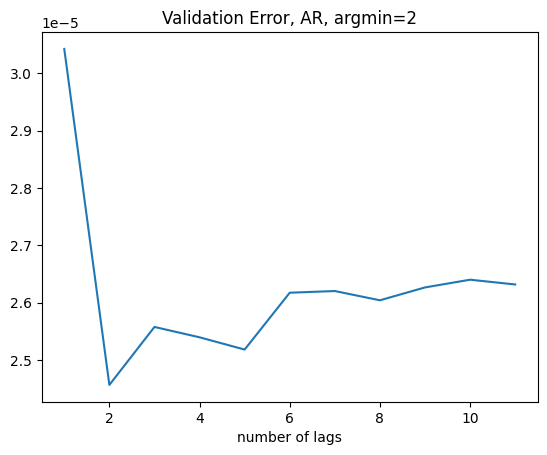

The RMSE of AR model is 0.003424


In [3]:
#######################################################################################
################################   AR, Validate  #####################################
#######################################################################################
ar_p_list = np.arange(1,12)

val_err = np.zeros((n_val, len(ar_p_list)))
AR_dict = {}
for cv_i, ar_p in enumerate(ar_p_list):

    lags_label = np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,ar_p)])

    AR_dict[cv_i] = LinearRegression(fit_intercept=True)
    AR_dict[cv_i].fit(X_train[lags_label], Y_train)
    # OLS.coef_

    Y_hat = AR_dict[cv_i].predict(X_val[lags_label])
    val_err[:, cv_i] = Y_val.values-Y_hat

val_err_AR = np.mean(np.array(val_err)**2, axis=0)
min_idx = np.argmin(val_err_AR)

plt.plot(ar_p_list,val_err_AR)
plt.xlabel('number of lags')
plt.title('Validation Error, AR, argmin=%i'%ar_p_list[min_idx])
plt.show()

lags_label = np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,ar_p_list[min_idx])])

Y_hat = AR_dict[min_idx].predict(X_test[lags_label])
test_err_AR = Y_test.values - Y_hat
RMSE_AR = np.sqrt(np.sum(test_err_AR**2)/len(test_err_AR))
print('The RMSE of AR model is %f'%RMSE_AR)

In [4]:
#######################################################################################
################################   Random Walk  #######################################
#######################################################################################
Y_hat = X_test['CPIAUCSL']
RMSE_RW = np.sqrt(np.mean((Y_test-Y_hat)**2))
print('The RMSE of RW model is %f'%RMSE_RW)

The RMSE of RW model is 0.003880


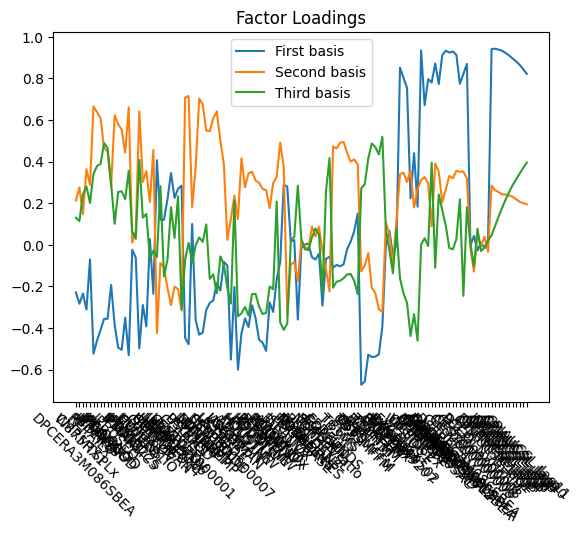

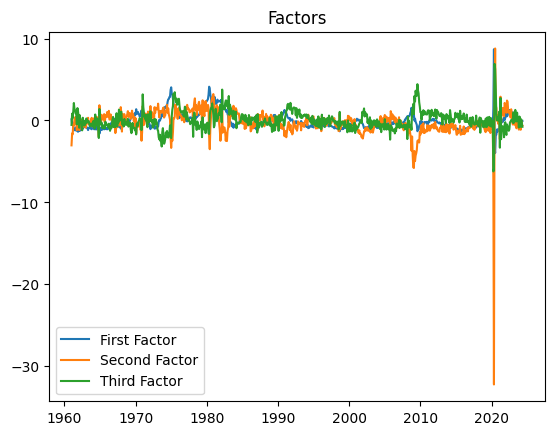

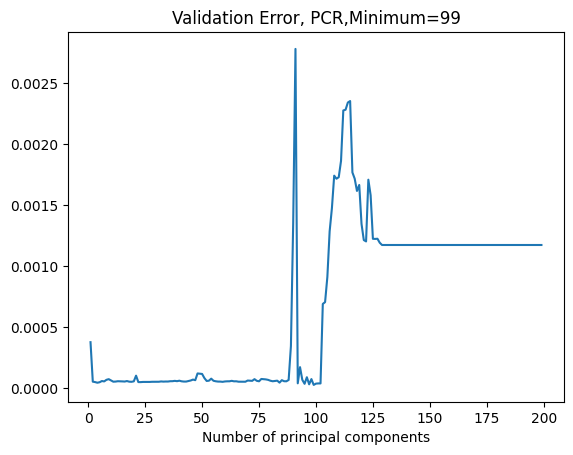

The RMSE of PCR is 0.005916


In [5]:
#######################################################################################
####################################   PCR    #########################################
#######################################################################################
X_train_stzd = (X_train_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_val_stzd = (X_val_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_test_stzd = (X_test_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0) 

Sigma_hat = X_train_stzd.T@X_train_stzd/n_train
eigval, eigvec = np.linalg.eig((Sigma_hat+Sigma_hat.T)/2)
eigval = np.real(eigval)
eigvec = np.real(eigvec)
idx = eigval.argsort()[::-1]
eigval_sorted = eigval[idx]
eigvec_sorted = eigvec[:, idx]
F_train = X_train_stzd @ eigvec_sorted
F_val = X_val_stzd @ eigvec_sorted
F_val.columns = F_train.columns
F_test = X_test_stzd @ eigvec_sorted
F_test.columns = F_test.columns


plt.plot(X_train_stzd.columns, eigvec_sorted[:,0]*np.sqrt(eigval_sorted)[0], label='First Loading')
plt.plot(X_train_stzd.columns, eigvec_sorted[:,1]*np.sqrt(eigval_sorted)[1], label='Second Loading')
plt.plot(X_train_stzd.columns, eigvec_sorted[:,2]*np.sqrt(eigval_sorted)[2], label='Third Loading')
plt.xticks(rotation=-45)
plt.title('Factor Loadings')
plt.legend()
plt.show()

plt.plot(Date_used,pd.concat((F_train.iloc[:,0],F_val.iloc[:,0],F_test.iloc[:,0]),axis=0)*(1/np.sqrt(eigval_sorted)[0]), label='First Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,1],F_val.iloc[:,1],F_test.iloc[:,1]),axis=0)*(1/np.sqrt(eigval_sorted)[1]), label='Second Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,2],F_val.iloc[:,2],F_test.iloc[:,2]),axis=0)*(1/np.sqrt(eigval_sorted)[2]), label='Third Factor')
plt.title('Factors')
plt.legend()
plt.show()

nfactors_list = np.arange(1,200)
val_err = np.zeros((n_val, len(nfactors_list)))
nfactors = 2
OLS_dict = {}
for cv_i, nfactors in enumerate(nfactors_list):
    OLS = LinearRegression(fit_intercept=True)
    OLS_dict[cv_i] = OLS.fit(F_train.iloc[:,:nfactors], Y_train)
    Y_hat = OLS_dict[cv_i].predict(F_val.iloc[:,:nfactors])
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_PCR = np.mean(np.array(val_err)**2, axis=0)

plt.plot(nfactors_list, val_err_PCR)
plt.xlabel('Number of principal components')
plt.title('Validation Error, PCR,Minimum=%i'%nfactors_list[min_idx])
plt.show()

PCR_nfactors = nfactors_list[min_idx]

Y_hat = OLS_dict[min_idx].predict(F_test.iloc[:,:nfactors_list[min_idx]])
test_err_PCR = Y_test.values - Y_hat
RMSE_PCR = np.sqrt(np.sum(test_err_PCR**2)/len(test_err_PCR))
print('The RMSE of PCR is %f'%RMSE_PCR)

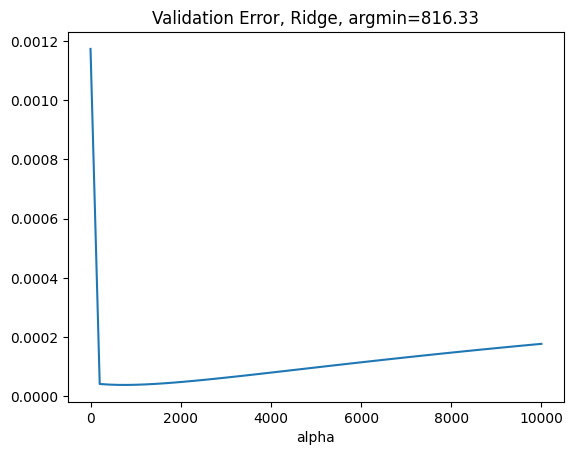

The RMSE of Ridge model is 0.004979


In [6]:
#######################################################################################
###################################   Ridge    ########################################
#######################################################################################
X_train_stzd = (X_train_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_val_stzd = (X_val_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_test_stzd = (X_test_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)    

alpha_list =np.linspace(0,10000,50)
val_err = np.zeros((n_val,len(alpha_list)))
Ridgemodel_dict = {}
for cv_i, alpha in enumerate(alpha_list):
    Ridgemodel_dict[cv_i] = Ridge(alpha=alpha,fit_intercept=True, random_state=seed)
    Ridgemodel_dict[cv_i].fit(X_train_stzd, Y_train)
    Y_hat = Ridgemodel_dict[cv_i].predict(X_val_stzd) 
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
min_idx_ridge = min_idx
val_err_Ridge = np.mean(np.array(val_err)**2, axis=0)

Ridge_alpha = alpha_list[min_idx]

plt.plot(alpha_list,val_err_Ridge)
plt.xlabel('alpha')
plt.title('Validation Error, Ridge, argmin=%0.2f'%alpha_list[min_idx])
plt.show()

Y_hat = Ridgemodel_dict[min_idx].predict(X_test_stzd)
test_err_Ridge = Y_test.values - Y_hat
RMSE_Ridge = np.sqrt(np.sum(test_err_Ridge**2)/len(test_err_Ridge))
print('The RMSE of Ridge model is %f'%RMSE_Ridge)

C:\Users\SangmyungHa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e-03, tolerance: 4.138e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\SangmyungHa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e-04, tolerance: 4.138e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\SangmyungHa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

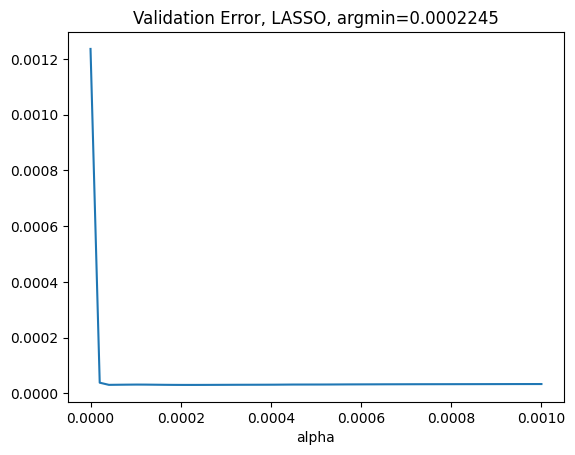

The RMSE of LASSO is 0.003818
         Variable Estimates
0       IPB51222S  0.000026
1        UEMP15OV -0.000004
2        UEMP27OV -0.000046
3   CES1021000001  0.000147
4        USWTRADE  0.000082
5          USFIRE  0.000171
6         HOUSTMW  0.000051
7          HOUSTW  0.000292
8          M2REAL -0.000226
9        FEDFUNDS  0.000013
10            GS5  0.000017
11            BAA  0.000183
12         T5YFFM -0.000532
13         BAAFFM -0.000045
14     WPSFD49502  0.000691
15      OILPRICEx  0.000233
16         PPICMM  0.000291
17       CPIAUCSL  0.017991
18       CPIAPPSL  0.000234
19       CPIMEDSL  0.000437
20    CUSR0000SAD  0.000322
21  CUSR0000SA0L5  0.007469
22  CES2000000008  0.000004


In [7]:
#######################################################################################
###################################   LASSO    ########################################
#######################################################################################
alpha_list = np.linspace(1e-15,0.001,50)
val_err = np.zeros((n_val,len(alpha_list)))
Lassomodel_dict = {}
for cv_i, alpha in enumerate(alpha_list):
    Lassomodel_dict[cv_i] = Lasso(alpha=alpha, fit_intercept=True,  warm_start=True, random_state=seed)
    Lassomodel_dict[cv_i].fit(X_train_stzd, Y_train)
    Y_hat = Lassomodel_dict[cv_i].predict(X_val_stzd) 
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_Lasso = np.mean(np.array(val_err)**2, axis=0)

plt.plot(alpha_list, val_err_Lasso)
plt.xlabel('alpha')
plt.title('Validation Error, LASSO, argmin=%0.7f'%alpha_list[min_idx])
plt.show()
# X_train_stzd.columns[Lassomodel_dict[min_idx].coef_ !=0]
# Lassomodel_dict[min_idx].coef_[Lassomodel_dict[min_idx].coef_ !=0]

LASSO_alpha = alpha_list[min_idx]

Y_hat = Lassomodel_dict[min_idx].predict(X_test_stzd)
test_err_Lasso = Y_test.values - Y_hat
RMSE_Lasso = np.sqrt(np.sum(test_err_Lasso**2)/len(test_err_Lasso))
print('The RMSE of LASSO is %f'%RMSE_Lasso)

LASSO_df = np.sum(Lassomodel_dict[min_idx].coef_ !=0)
nonzero_beta = pd.DataFrame(((X_train_stzd.columns[Lassomodel_dict[min_idx].coef_ !=0],
                            Lassomodel_dict[min_idx].coef_[Lassomodel_dict[min_idx].coef_ !=0]))).T
nonzero_beta.columns = ['Variable','Estimates']
print(nonzero_beta)

C:\Users\SangmyungHa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e-03, tolerance: 4.138e-05
  model = cd_fast.enet_coordinate_descent(


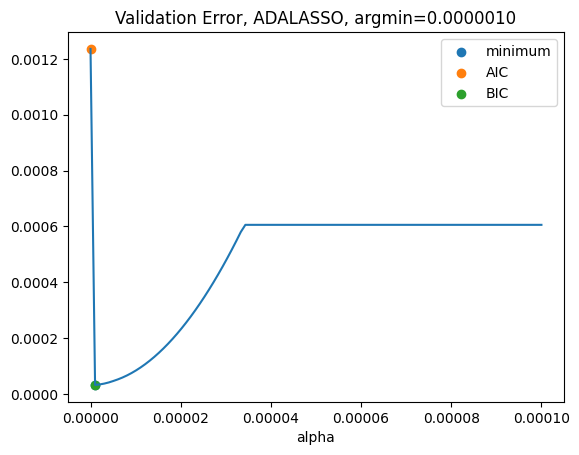

The RMSE of Adaptive LASSO is 0.003968
        Variable  Estimates
0       CPIAUCSL  10.555505
1    CUSR0000SAC   0.210786
2  CUSR0000SA0L5  11.117454


In [8]:
#######################################################################################
###################################   ADALASSO    #####################################
#######################################################################################
X_train_stzd_tilde = X_train_stzd*np.abs(Ridgemodel_dict[min_idx_ridge].coef_)
X_val_stzd_tilde = X_val_stzd*np.abs(Ridgemodel_dict[min_idx_ridge].coef_)
X_test_stzd_tilde = X_test_stzd*np.abs(Ridgemodel_dict[min_idx_ridge].coef_)

alpha_list = np.linspace(1e-14,0.0001,100)
val_err = np.zeros((n_val,len(alpha_list)))
AIC = np.zeros((len(alpha_list),))
BIC = np.zeros((len(alpha_list),))
AdaLassomodel_dict = {}
for cv_i, alpha in enumerate(alpha_list):
    AdaLassomodel_dict[cv_i] = Lasso(alpha=alpha, fit_intercept=True,  warm_start=True, random_state=seed)
    AdaLassomodel_dict[cv_i].fit(X_train_stzd_tilde, Y_train)

    DF = np.sum(AdaLassomodel_dict[cv_i].coef_ !=0)
    RSS = np.sum((Y_train-AdaLassomodel_dict[cv_i].predict(X_train_stzd_tilde))**2)
    BIC[cv_i] = n_train*np.log(RSS) + DF*np.log(n_train)
    AIC[cv_i] = n_train*np.log(RSS) + DF*2
    
    Y_hat = AdaLassomodel_dict[cv_i].predict(X_val_stzd_tilde) 
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_AdaLasso = np.mean(np.array(val_err)**2, axis=0)

min_idx_AIC = np.argmin(AIC)
min_idx_BIC = np.argmin(BIC)

plt.plot(alpha_list, val_err_AdaLasso)
plt.scatter(alpha_list[min_idx],val_err_AdaLasso[min_idx],label='minimum')
plt.scatter(alpha_list[min_idx_AIC],val_err_AdaLasso[min_idx_AIC],label='AIC')
plt.scatter(alpha_list[min_idx_BIC],val_err_AdaLasso[min_idx_BIC],label='BIC')
plt.xlabel('alpha')
plt.title('Validation Error, ADALASSO, argmin=%0.7f'%alpha_list[min_idx])
plt.legend()
plt.show()

AdaLasso_alpha = val_err_AdaLasso[min_idx]

Y_hat = AdaLassomodel_dict[min_idx].predict(X_test_stzd_tilde)
test_err_adaLasso = Y_test.values - Y_hat
RMSE_AdaLasso = np.sqrt(np.sum(test_err_adaLasso**2)/len(test_err_adaLasso))
print('The RMSE of Adaptive LASSO is %f'%RMSE_AdaLasso)

AdaLASSO_df = np.sum(AdaLassomodel_dict[min_idx].coef_ !=0)

nonzero_beta = pd.DataFrame(((X_train_stzd.columns[AdaLassomodel_dict[min_idx].coef_ !=0],
                            AdaLassomodel_dict[min_idx].coef_[AdaLassomodel_dict[min_idx].coef_ !=0]))).T
nonzero_beta.columns = ['Variable','Estimates']
print(nonzero_beta)


# Partially Linear Models

In [9]:
num_lags = 2
V_used = X_used[np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,num_lags)])]
W_used = X_used.drop(np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,12)]),axis=1)

n = X_used.shape[0]

forecast_period = pd.to_datetime('2015-01-01')<=Date_used
forecast_idx = np.where(forecast_period)[0]
n_test = np.sum(forecast_period)

validation_period = (pd.to_datetime('2005-08-01')<=Date_used) & (pd.to_datetime('2015-01-01') > Date_used)
validation_idx = np.where(validation_period)[0]
n_val = np.sum(validation_period)

training_period = pd.to_datetime('2005-08-01')>Date_used
training_idx = np.where(training_period)[0]
n_train = np.sum(training_period)


V_train = V_used.loc[training_period]
W_train = W_used.loc[training_period,:]
Y_train = Y_used.loc[training_period]

V_val = V_used.loc[validation_period]
W_val = W_used.loc[validation_period,:]
Y_val = Y_used.loc[validation_period]

V_test = V_used.loc[forecast_period]
W_test = W_used.loc[forecast_period,:]
Y_test = Y_used.loc[forecast_period]

nnan_idx = np.sum(np.isnan(W_used),axis=0)==0
W_used_nnan = W_used.loc[:,nnan_idx]

W_train_nnan = W_used_nnan.loc[training_period,:]
W_val_nnan = W_used_nnan.loc[validation_period,:]
W_test_nnan = W_used_nnan.loc[forecast_period,:]

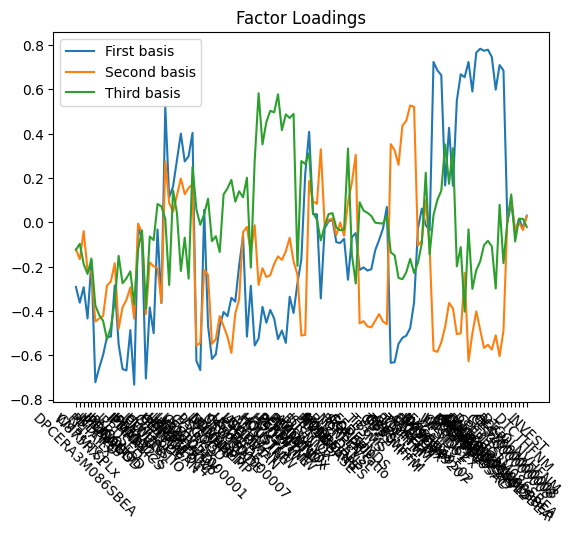

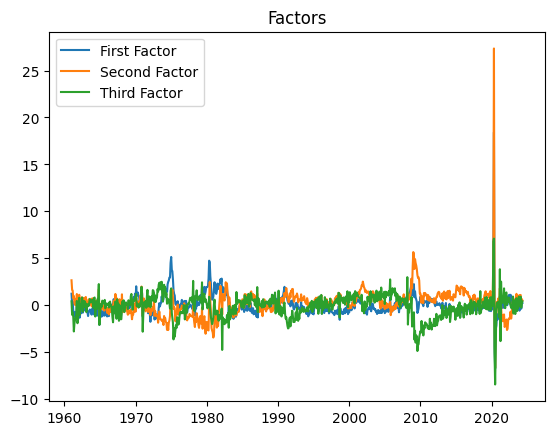

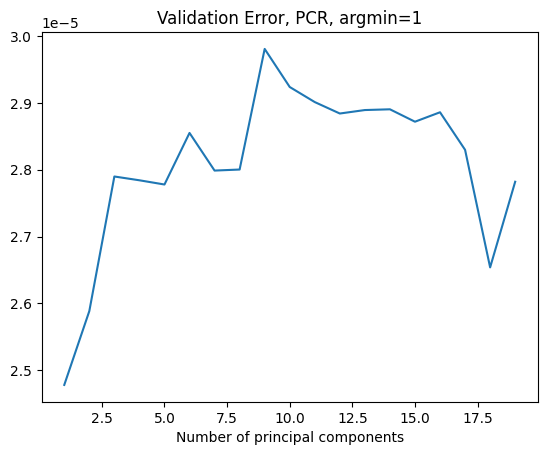

The RMSE of PCR is 0.003587


In [10]:
#######################################################################################
####################################   PCR    #########################################
#######################################################################################
W_train_stzd = (W_train_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_val_stzd = (W_val_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_test_stzd = (W_test_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)    

Sigma_hat = W_train_stzd.T@W_train_stzd/n_train
eigval, eigvec = np.linalg.eig(Sigma_hat)
eigval = np.real(eigval)
eigvec = np.real(eigvec)
idx = eigval.argsort()[::-1]
eigval_sorted = eigval[idx]
eigvec_sorted = eigvec[:, idx]
F_train = W_train_stzd @ eigvec_sorted
F_val = W_val_stzd @ eigvec_sorted
F_val.columns = F_train.columns
F_test = W_test_stzd @ eigvec_sorted
F_test.columns = F_test.columns


plt.plot(W_train_stzd.columns, eigvec_sorted[:,0]*np.sqrt(eigval_sorted)[0], label='First Loading')
plt.plot(W_train_stzd.columns, eigvec_sorted[:,1]*np.sqrt(eigval_sorted)[1], label='Second Loading')
plt.plot(W_train_stzd.columns, eigvec_sorted[:,2]*np.sqrt(eigval_sorted)[2], label='Third Loading')
plt.xticks(rotation=-45)
plt.title('Factor Loadings')
plt.legend()
plt.show()

plt.plot(Date_used,pd.concat((F_train.iloc[:,0],F_val.iloc[:,0],F_test.iloc[:,0]),axis=0)*(1/np.sqrt(eigval_sorted)[0]), label='First Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,1],F_val.iloc[:,1],F_test.iloc[:,1]),axis=0)*(1/np.sqrt(eigval_sorted)[1]), label='Second Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,2],F_val.iloc[:,2],F_test.iloc[:,2]),axis=0)*(1/np.sqrt(eigval_sorted)[2]), label='Third Factor')
plt.title('Factors')
plt.legend()
plt.show()

nfactors_list = np.arange(1,20)
val_err = np.zeros((n_val, len(nfactors_list)))
nfactors = 2
PCR_dict = {}
beta_dict_PCR = {}
for cv_i, nfactors in enumerate(nfactors_list):

    PCR_dict[cv_i] = LinearRegression(fit_intercept=True)
    PCR_dict[cv_i].fit(np.concatenate((V_train.values,F_train.iloc[:,:nfactors]),axis=1), Y_train)
    
    
    Y_hat = PCR_dict[cv_i].predict(np.concatenate((V_val.values,F_val.iloc[:,:nfactors]),axis=1))
    
    beta_dict_PCR[cv_i] = PCR_dict[cv_i].coef_[:2]
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_PCR = np.mean(np.array(val_err)**2, axis=0)

plt.plot(nfactors_list, val_err_PCR)
plt.xlabel('Number of principal components')
plt.title('Validation Error, PCR, argmin=%i'%nfactors_list[min_idx])
plt.show()

PL_PCR_nfactors = nfactors_list[min_idx]

Y_hat = PCR_dict[min_idx].predict(np.concatenate((V_test.values,F_test.iloc[:,:nfactors_list[min_idx]]),axis=1))
test_err_PL_PCR = Y_test.values - Y_hat
RMSE_PL_PCR = np.sqrt(np.sum(test_err_PL_PCR**2)/len(test_err_PL_PCR))
print('The RMSE of PCR is %f'%RMSE_PL_PCR)

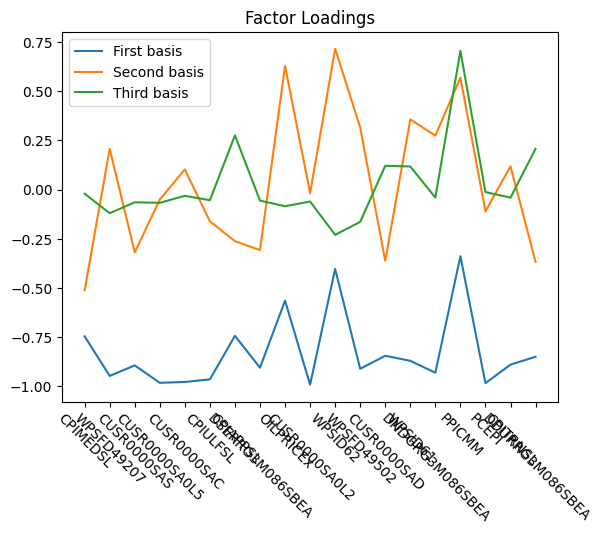

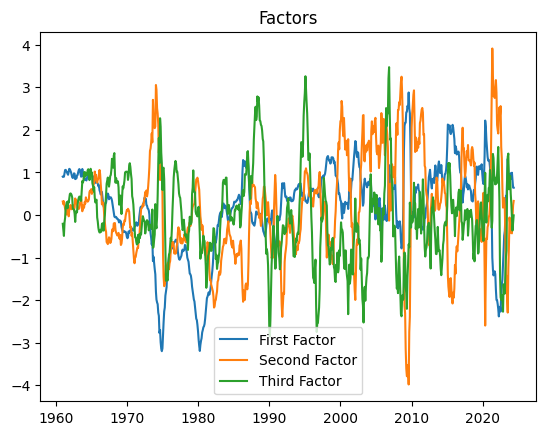

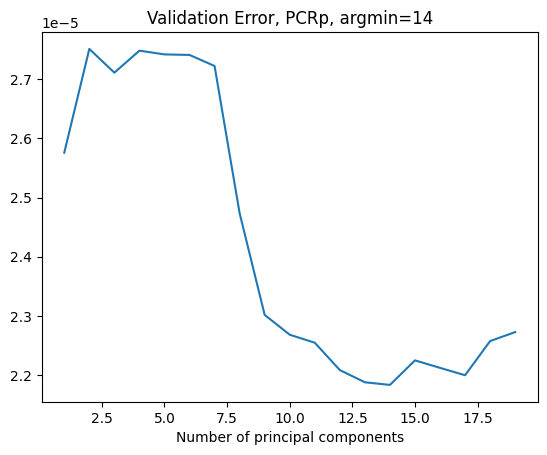

The RMSE of PCRp is 0.003083


In [11]:
#######################################################################################
####################################   PCRp    #########################################
#######################################################################################
W_train_stzd2 = (W_train_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_val_stzd2 = (W_val_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_test_stzd2 = (W_test_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)

W_train_stzd = W_train_stzd2[list(set(W_train_stzd2.columns).intersection(set(price_var)))]
W_val_stzd = W_val_stzd2[list(set(W_train_stzd2.columns).intersection(set(price_var)))]
W_test_stzd = W_test_stzd2[list(set(W_train_stzd2.columns).intersection(set(price_var)))]

Sigma_hat = W_train_stzd.T@W_train_stzd/n_train
eigval, eigvec = np.linalg.eig(Sigma_hat)
eigval = np.real(eigval)
eigvec = np.real(eigvec)
idx = eigval.argsort()[::-1]
eigval_sorted = eigval[idx]
eigvec_sorted = eigvec[:, idx]
F_train = W_train_stzd @ eigvec_sorted
F_val = W_val_stzd @ eigvec_sorted
F_val.columns = F_train.columns
F_test = W_test_stzd @ eigvec_sorted
F_test.columns = F_test.columns


plt.plot(W_train_stzd.columns, eigvec_sorted[:,0]*np.sqrt(eigval_sorted)[0], label='First Loading')
plt.plot(W_train_stzd.columns, eigvec_sorted[:,1]*np.sqrt(eigval_sorted)[1], label='Second Loading')
plt.plot(W_train_stzd.columns, eigvec_sorted[:,2]*np.sqrt(eigval_sorted)[2], label='Third Loading')
plt.xticks(rotation=-45)
plt.title('Factor Loadings')
plt.legend()
plt.show()

plt.plot(Date_used,pd.concat((F_train.iloc[:,0],F_val.iloc[:,0],F_test.iloc[:,0]),axis=0)*(1/np.sqrt(eigval_sorted)[0]), label='First Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,1],F_val.iloc[:,1],F_test.iloc[:,1]),axis=0)*(1/np.sqrt(eigval_sorted)[1]), label='Second Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,2],F_val.iloc[:,2],F_test.iloc[:,2]),axis=0)*(1/np.sqrt(eigval_sorted)[2]), label='Third Factor')
plt.title('Factors')
plt.legend()
plt.show()


nfactors_list = np.arange(1,20)
val_err = np.zeros((n_val, len(nfactors_list)))
PCRp_dict = {}
beta_dict_PCRp = {}
for cv_i, nfactors in enumerate(nfactors_list):

    PCRp_dict[cv_i] = LinearRegression(fit_intercept=True)
    PCRp_dict[cv_i].fit(np.concatenate((V_train.values,F_train.iloc[:,:nfactors]),axis=1), Y_train)
    
    Y_hat = PCRp_dict[cv_i].predict(np.concatenate((V_val.values,F_val.iloc[:,:nfactors]),axis=1))
    
    beta_dict_PCRp[cv_i] = PCRp_dict[cv_i].coef_[:2]
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_PCRp = np.mean(np.array(val_err)**2, axis=0)

plt.plot(nfactors_list, val_err_PCRp)
plt.xlabel('Number of principal components')
plt.title('Validation Error, PCRp, argmin=%i'%nfactors_list[min_idx])
plt.show()

PL_PCRp_nfactors=nfactors_list[min_idx]

Y_hat = PCRp_dict[min_idx].predict(np.concatenate((V_test.values,F_test.iloc[:,:nfactors_list[min_idx]]),axis=1))
test_err_PL_PCRp = Y_test.values - Y_hat
RMSE_PL_PCRp = np.sqrt(np.sum(test_err_PL_PCRp**2)/len(test_err_PL_PCRp))
print('The RMSE of PCRp is %f'%RMSE_PL_PCRp)

## RMSE Comparisons

In [12]:
lags_label = np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,2)])
AR = LinearRegression(fit_intercept=True)
AR.fit(X_train[lags_label], Y_train)
Y_hat = AR.predict(X_test[lags_label])

test_err_AR = Y_test.values - Y_hat
RMSE_AR = np.sqrt(np.sum(test_err_AR**2)/len(test_err_AR))
print('The RMSE of AR model is %f'%RMSE_AR)

The RMSE of AR model is 0.003424


In [13]:
AR_rlt = [2,RMSE_AR]
PCR_rlt = [PCR_nfactors, RMSE_PCR]
Ridge_rlt = [Ridge_alpha, RMSE_Ridge]
LASSO_rlt = ['%f, df=%i'%(LASSO_alpha,LASSO_df), RMSE_Lasso]
AdaLasso_rlt = ['%f, df=%i'%(AdaLasso_alpha,AdaLASSO_df ), RMSE_AdaLasso]
PL_PCR_rlt = [PL_PCR_nfactors, RMSE_PL_PCR]
PL_PCRp_rlt = [PL_PCRp_nfactors, RMSE_PL_PCRp]

RESULTS = [AR_rlt,PCR_rlt, Ridge_rlt, LASSO_rlt, AdaLasso_rlt, PL_PCR_rlt, PL_PCRp_rlt]
RESULTS_pd = pd.DataFrame(RESULTS)
RESULTS_pd.columns = ['parameters','RMSE']
RESULTS_pd.index = ['AR','PCR','Ridge','LASSO','AdaLASSO','PL_PCR','PL_PCRp']
display(RESULTS_pd)

,parameters,RMSE
AR,2,0.003424
PCR,99,0.005916
Ridge,816.326531,0.004979
LASSO,"0.000224, df=23",0.003818
AdaLASSO,"0.000032, df=3",0.003968
PL_PCR,1,0.003587
PL_PCRp,14,0.003083


In [14]:
rolling_RMSE_AR = np.zeros((n_test-24,))
rolling_RMSE_PCR = np.zeros((n_test-24,))
rolling_RMSE_Ridge = np.zeros((n_test-24,))
rolling_RMSE_LASSO = np.zeros((n_test-24,))
rolling_RMSE_ADALASSO = np.zeros((n_test-24,))
rolling_RMSE_PL_PCR = np.zeros((n_test-24,))
rolling_RMSE_PL_PCRp = np.zeros((n_test-24,))

rolling_RMSE_PL_PCRp = np.zeros((n_test-24,))
for j in range(n_test-24):
    rolling_RMSE_AR[j] = np.sqrt(np.sum(test_err_AR[j:j+24]**2)/24)
    rolling_RMSE_PCR[j] = np.sqrt(np.sum(test_err_PCR[j:j+24]**2)/24)
    rolling_RMSE_Ridge[j] = np.sqrt(np.sum(test_err_Ridge[j:j+24]**2)/24)
    rolling_RMSE_LASSO[j] = np.sqrt(np.sum(test_err_Lasso[j:j+24]**2)/24)
    rolling_RMSE_ADALASSO[j] = np.sqrt(np.sum(test_err_adaLasso[j:j+24]**2)/24)
    rolling_RMSE_PL_PCR[j] = np.sqrt(np.sum(test_err_PL_PCR[j:j+24]**2)/24)
    rolling_RMSE_PL_PCRp[j] = np.sqrt(np.sum(test_err_PL_PCRp[j:j+24]**2)/24)


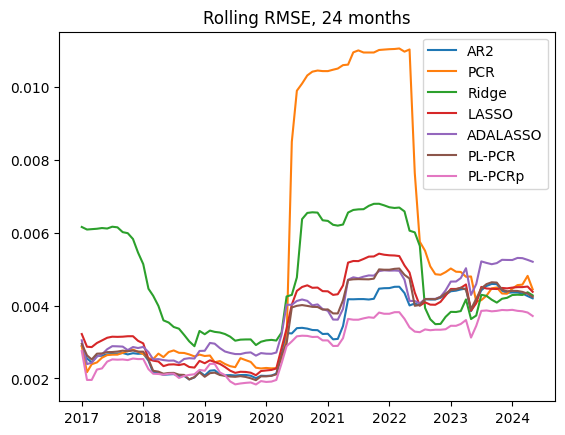

In [15]:
# training_idx = np.where(training_period)[0]

plt.plot(Date_used[forecast_period][24:],rolling_RMSE_AR,label='AR2')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_PCR,label='PCR')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_Ridge,label='Ridge')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_LASSO,label='LASSO')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_ADALASSO,label='ADALASSO')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_PL_PCR,label='PL-PCR')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_PL_PCRp,label='PL-PCRp')
plt.title('Rolling RMSE, 24 months')
plt.legend()
plt.show()

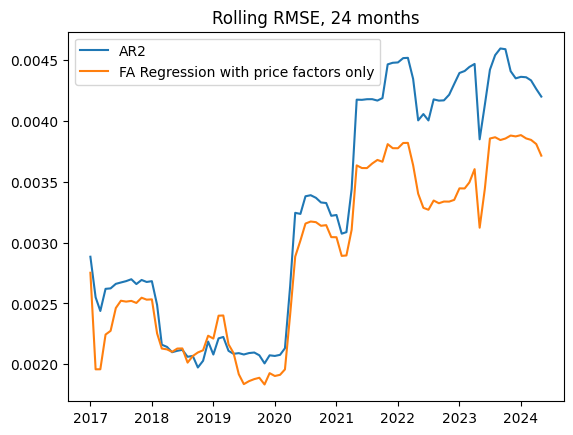

In [18]:
# training_idx = np.where(training_period)[0]

plt.plot(Date_used[forecast_period][24:],rolling_RMSE_AR,label='AR2')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_PL_PCRp,label='FA Regression with price factors only')
plt.title('Rolling RMSE, 24 months')
plt.legend()
plt.show()